# **Импорт всех пакетов**

In [1]:
import tensorflow as tf
import keras
from keras import layers, regularizers, optimizers
from keras.layers import (
    Dense,
    Add,
    Flatten,
    Input,
    Activation,
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dropout,
    Lambda,
    concatenate,
)
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import cv2
import numpy as np
from numpy import load, save
import re
import keras.backend as K

import json
from tqdm.notebook import trange, tqdm

K.set_image_data_format("channels_last")
K.set_learning_phase(1)

WIDTH = 128  # Размер изображения 128

/home/voland/.local/lib/python3.6/site-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


# **Предварительная обработка изображения и данных**

In [32]:
# Reading train.parquet file using pandas
train = pd.read_parquet("train.parquet", engine="pyarrow")
test = pd.read_parquet("test.parquet", engine="pyarrow")

In [4]:
train.head(1)

,product_id,category_id,sale,shop_id,shop_title,rating,text_fields,category_name
0,325286,12171,False,9031,Aksik,5.0,"{""title"": ""Зарядный кабель Borofone BX1 Lightn...",Все категории->Электроника->Смартфоны и телефо...


In [5]:
test.head(1)

,product_id,sale,shop_id,shop_title,rating,text_fields
1,1997646,False,22758,Sky_Electronics,5.0,"{""title"": ""Светодиодная лента Smart led Strip ..."


Разделим категории на подкатегории и посмотрим сколько уникальных категорий содержит наш набор

In [6]:
query_train = train.category_name.str.split("->", 5, expand=True)

In [7]:
query_train.head(2)

,0,1,2,3,4,5
0,Все категории,Электроника,Смартфоны и телефоны,Аксессуары и запчасти,Зарядные устройства и кабели,Кабели
1,Все категории,Одежда,Женская одежда,Белье и купальники,Трусы,None


In [8]:
for i in range(5):
    print(
        i,
        "Have None in %d values? --> %s"
        % (query_train[i].nunique(), (None in query_train[i].unique())),
    )

0 Have None in 1 values? --> False
1 Have None in 5 values? --> False
2 Have None in 45 values? --> False
3 Have None in 278 values? --> True
4 Have None in 532 values? --> True


2 колонка разбивается на категории без Нан значений. 
Таким образом: 

Нужно было предсказывать 45 уникальных категорий, а не category_id.
Но мы пойдем по заданию

Обработка text_fields состоит в распаковке JSON списка по столбцам

In [14]:
# Возьмем названия колонок в JSON словаре
col_tf = train["text_fields"].apply(json.loads)[0].keys()
# Разобьем наши данные из text_fields по столбцам
for col in col_tf:
    train[col] = train["text_fields"].apply(json.loads).apply(lambda x: x[col])

# Удалим обработанную колонку
train = train.drop(columns=["text_fields"], axis=1)

In [20]:
# Создание численных меток category_id в наших данных
train["uniq_labels"] = train["category_id"].astype("category").cat.codes

У нас сейчас есть численные labels для работы

/home/voland/anaconda3/envs/rtx_3060/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='labels', ylabel='count'>

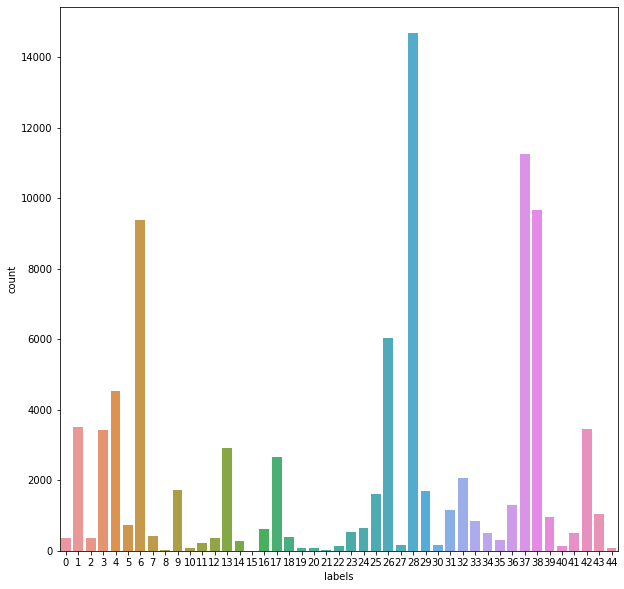

In [21]:
# Let's have a look at the label distribution
plt.figure(figsize=(10, 10))
sns.countplot(train["uniq_labels"])

Как вы можете видеть, на labels 28 произошло больше всего количества раз, что составляет около 14000. Есть много labels, которые происходят менее чем в 1000 раз.Есть 12 labels, которые происходили более 2000 раз. 

Надо решить задачу многоклассовой классификации. В качестве метрики для задания выбран взвешенный F1-score

In [24]:
train["category_id"].nunique()

874

In [ ]:
# Теперь давайте создадим множество тренировочных лейблов.
train_labels = train["category_id"]
train_labels = np.array(train_labels)

# **Text PreProcessing**

Создадим функцию удаления знаков, которая удалит знаки препинания, числа и дополнительные места с конца предложения. Она также заменит буквы верхнего регистра в нижний

In [26]:
train.head(1)

,product_id,category_id,sale,shop_id,shop_title,rating,category_name,title,description,attributes,custom_characteristics,defined_characteristics,filters
0,325286.jpg,12171,False,9031,Aksik,5.0,Смартфоны и телефоны,Зарядный кабель Borofone BX1 Lightning для айф...,"<p><span style=""background-color: transparent;...","[Длина: 1м, Разъем: Lightning, Подерживает быс...",{},"{'Цвет': ['Черный', 'Белый']}","{'Цвет': ['Белый', 'Черный']}"


In [32]:
col_cat = [
    "shop_title",
    "rating",
    "category_name",
    "title",
    "description",
    "attributes",
    "custom_characteristics",
    "defined_characteristics",
    "filter",
]

TypeError: list() takes at most 1 argument (9 given)

In [ ]:
def clean_text(data):
    # На этом этапе мы преобразуем Charecters в нижний чехол
    for i in range(data.shape[0]):
        data[i] = data[i].lower()
    # На этом этапе мы удаляем числа и знаки препинания из текста
    for i in range(data.shape[0]):
        data[i] = re.sub(r"[^\w\s]+|[\d]+", "", data[i])
        #  выбрасывает все слова (преимущественно предлоги), длинна которых меньше 3-х символов.
        data[i] = " ".join(word for word in data[i].split() if len(word) > 3)
    # Здесь мы снимаем дополнительное пространство с конца и начала предложения
    for i in range(data.shape[0]):
        data[i] = data[i].strip()
    return data

In [9]:
# Максимальное количество слов, которые будут использоваться.
MAX_NB_WORDS = 5000
# Максимальное количество слов в каждом имени.
MAX_SEQUENCE_LENGTH = 15
EMBEDDING_DIM = 100

In [29]:
X_train = []
for col in col_cat:
    names = np.array(train[col].astype(str))
    # Применение функции clean_text для получения чистых текстовых данных
    names = clean_text(names)
    # Создание токенов слова
    tokenizer = Tokenizer(
        num_words=MAX_NB_WORDS,
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
        lower=True,
        char_level=False,
    )
    tokenizer.fit_on_texts(names)
    word_index = tokenizer.word_index

    print("Found %s unique tokens." % len(word_index))
    # Наконец мы создаем наши текстовые данные для обучения
    X = tokenizer.texts_to_sequences(
        names
    )  # Здесь он берет каждое слово от имен и заменяет его соответствующим номером от нашего Word_index
    X = pad_sequences(
        X, maxlen=MAX_SEQUENCE_LENGTH
    )  # Он преобразует список последовательностей в массив формы Numpy (num_sequence, num_timestep)
    # Где числовая последовательность - это количество предложений в именах, а num_timestep - это количество слов в каждом предложении, которое в данном случае составляет 15.
    print("Shape of data tensor:", X.shape)
    X_train.append(X)


NameError: name 'col_cat' is not defined

 **Сравните данные перед чисткой и после чистки**
 
 **Перед чисткой :** 
'Холсты грунтованные на деревяном подрамнике'

 **После уборки :**  
'холсты грунтованные деревяном подрамнике'

Вы можете видеть, что мы изменили заглавные буквы и удалили числа, знаки препинания и дополнительные места с конца предложения.

У нас есть 356090 уникальных токенов, которые мы будем использовать для обучения нашей текстовой модели.

In [ ]:
# Здесь вы можете увидеть массив, где для каждого примера (предложение) у нас есть 15 функций (слова).
X_train

In [ ]:
# Теперь давайте создадим наборы данных поезда и тестирование
X_traintext = X_train[0:80000, :]
X_testtext = X_train[80000:, :]
Y_train = train_labels[0:80000, :]
Y_train = train_labels[0:80000, :]

Сохранение текстовых данных Preprocessesd для будущего использования

In [ ]:
save("train_text.npy", X_traintext)
save("test_text.npy", X_testtext)

Мы можем перезагрузить текстовые данные с помощью кода ниже

In [3]:
X_traintext = load("train_text.npy")
X_testtext = load("test_text.npy")

# **Text Embeddings**

Обучим небольшую модель для текстаь.

In [10]:
# Создание TextModel
textmodel = Sequential()
# Мы начинаем с эффективного встроенного слоя, который карты
# Наши индексы слока в размеры Embedding_dims
textmodel.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_traintext.shape[1]))
textmodel.add(Dropout(0.2))

# Мы добавляем Convolution1d, которая изучит фильтры
# Группа слов фильтры по размеру filter_length:
textmodel.add(Conv1D(256, 5, padding="valid", activation="relu", strides=1))
# Мы используем Max Pooling:
textmodel.add(GlobalMaxPooling1D())

# Добавляем полностью подключенный скрытый слой:
textmodel.add(Dense(512))
textmodel.add(Dropout(0.2))
textmodel.add(Activation("relu"))

# **Implementing Text tower**

In [11]:
# Создание модели Text_tower
# мы собираемся использовать 2 скрытого плотного слоя с 512 единицами каждый
# Dropout 0,15 между всеми скрытыми слоями.
# используется L2 -нормализация 
text_tower = Sequential()
text_tower.add(Dense(512, activation="relu"))
text_tower.add(Dropout(0.15))
text_tower.add(
    Dense(512, activation="relu")
)  # Last layer with D=512 hidden units followed by L2 normalization.
# L2 normalizaton.
text_tower.add(Lambda(lambda xz: K.l2_normalize(xz, axis=1)))

Теперь мы добавим модель text_tower в текст embedding model

In [12]:
# Добавление text_tower в TextModel
textmodel.add(text_tower)

# **Final Model**

In [24]:
# merged = concatenate(model.output, textmodel.output)  # Объединение обеих моделей
out = Dense(874)(textmodel.output)  # Добавление плотного слоя в объединенные слои
# Добавление активации Softmax для классификации
# Окончательная модель, которую мы будем использовать для классификации
out = Activation("softmax")(out)
final_model = Model(
    textmodel.input, out
) 

# **Class Level Similarity**

In [16]:
# https://stackoverflow.com/questions/59963911/how-to-write-a-custom-f1-loss-function-with-weighted-average-for-keras
def get_f1(true, pred):  # shapes (batch, 4)

    ground_positives = K.sum(true, axis=0) + K.epsilon()  # = TP + FN
    pred_positives = K.sum(pred, axis=0) + K.epsilon()  # = TP + FP
    true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP

    precision = true_positives / pred_positives
    recall = true_positives / ground_positives

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    # still with shape (4,)

    weighted_f1 = f1 * ground_positives / K.sum(ground_positives)
    weighted_f1 = K.sum(weighted_f1)

    return weighted_f1  # for metrics, return only 'weighted_f1'

In [26]:
from tensorflow.keras import (
    optimizers,
)  # переустановить библиотеку так как не находит rmsprob

# При использовании метрик в model.compile в keras сообщите ValueError: («Неизвестная метрическая функция», «: f1score»)
# На компьютере установлена старая библиотека keras

final_model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1.6192e-5),
    # optimizer=optimizers.experimental.Adafactor(learning_rate=1.6192e-5),
    loss="categorical_crossentropy",
    metrics=[get_f1],
)

In [14]:
# Проверка доступа к видеокарте
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [15]:
!nvidia-smi


Tue Mar 21 00:40:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:09:00.0  On |                  N/A |
|  0%   46C    P2    54W / 170W |  10507MiB / 12288MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Finally training our model

In [28]:
final_model.fit(X_traintext, Y_train, batch_size=256, epochs=400, validation_split=0.05)

Epoch 1/400
297/297 [==============================] - 1s 3ms/step - loss: 2.4029 - get_f1: 0.3057 - accuracy: 0.5906 - val_loss: 2.4257 - val_get_f1: 0.3154 - val_accuracy: 0.5987
Epoch 2/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3834 - get_f1: 0.3102 - accuracy: 0.5935 - val_loss: 2.4070 - val_get_f1: 0.3197 - val_accuracy: 0.6003
Epoch 3/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3637 - get_f1: 0.3141 - accuracy: 0.5966 - val_loss: 2.3891 - val_get_f1: 0.3236 - val_accuracy: 0.6003
Epoch 4/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3443 - get_f1: 0.3182 - accuracy: 0.5992 - val_loss: 2.3718 - val_get_f1: 0.3276 - val_accuracy: 0.6037
Epoch 5/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3258 - get_f1: 0.3224 - accuracy: 0.6017 - val_loss: 2.3525 - val_get_f1: 0.3320 - val_accuracy: 0.6075
Epoch 6/400
297/297 [==============================] - 1s 3ms/step - loss: 2.3068 - get_f1: 0.3

Evaluating model on test set

In [29]:
final_model.evaluate(X_testtext, Y_test)

348/348 [==============================] - 1s 1ms/step - loss: 1.0745 - get_f1: 0.7685 - accuracy: 0.7960


[1.0745106935501099, 0.7684622406959534, 0.7960431575775146]

In [30]:
final_model.save("text_model.h5")

In [31]:
final_model.save_weights("text_model_weights.h5")

In [ ]:
# Predicting on X_test and X_testtext datasets
pred = inter_output_model.predict(X_testtext)

In [47]:
test

,product_id,sale,shop_id,shop_title,rating,text_fields,title,description,attributes,custom_characteristics,defined_characteristics,filters
1,1997646,False,22758,Sky_Electronics,5.000000,"{""title"": ""Светодиодная лента Smart led Strip ...","Светодиодная лента Smart led Strip Light, с пу...","<p>Светодиодная лента LED, 5 м, RGB (Цветная) ...","[Легкость управления с пульта, а так же смартф...",{},{},"{'Тип питания': ['От сети', 'От USB'], 'В комп..."
2,927375,False,17729,Di-Di Market,4.405941,"{""title"": ""Стекло ПЛЕНКА керамик матовое Honor...",Стекло ПЛЕНКА керамик матовое Honor 50 lite 10...,"<p><span style=""color: rgb(63, 62, 62);"">Защит...",[Honor 50 ПЛЕНКА!!! КРАЯ КЛЕЮТСЯ МОГУТ НЕ ПРО...,"{'Модель': ['8a - Y6 2019', '9x - P Smart Z', ...",{},"{'Модель устройства': ['Honor 9X', 'Honor 20 P..."
3,1921513,False,54327,VisionStore,4.000000,"{""title"": ""Проводные наушники с микрофоном jac...","Проводные наушники с микрофоном jack 3.5, IOS,...",<p>Наушники проводные с микрофоном отличное ка...,[Возможность использования как гарнитуры для П...,{},{},"{'Разъем': ['3.5 мм'], 'Конструкция наушников'..."
4,1668662,False,15000,FORNAILS,5.000000,"{""title"": ""Декоративная табличка \""Правила кух...","Декоративная табличка ""Правила кухни"", подстав...","<p>Декоративная табличка ""Правила кухни"" созда...",[],{},{},{'Бренд': ['FORNAILS']}
5,1467778,False,39600,МОЯ КУХНЯ,5.000000,"{""title"": ""Подставка под ложку керамическая, п...","Подставка под ложку керамическая, подложка ""Кл...",<p>Подложка керамическая с рисунком в подарочн...,"[Керамика., Размер: 255*90*30мм; ]","{'Модель': ['Клубника', 'Лимоны', 'Лаванда']}",{},"{'Бренд': ['Valleya', 'Valleya', 'Valleya']}"
...,...,...,...,...,...,...,...,...,...,...,...,...
24987,1914264,False,8598,Zoorbox,4.913043,"{""title"": ""Жесткий диск внутренний SSD KingDia...",Жесткий диск внутренний SSD KingDian 2.5 Inch ...,"<p><img src=""https://ke-images.servicecdn.ru/c...","[Интерфейс SSD SATA3 6.0 Гбит/с, Форм-фактор 2...","{'Объем памяти': ['128 гб', '256 гб', '512 гб'...",{},{}
24988,1310569,False,27474,RenRin,5.000000,"{""title"": ""Браслет оберег на руку/красная нить...",Браслет оберег на руку/красная нить от сглаза/...,"<p>Красная нить - оберег, обладающий большой с...","[Насыщенный красный цвет, Хорошее плетение, Ун...",{},{},{}
24989,978095,False,23395,Хобби и Ты,5.000000,"{""title"": ""Кабошон бантик в упаковке 2 шт"", ""d...",Кабошон бантик в упаковке 2 шт,"<p>Кабошон бантик, желтого цвета. Используется...","[Размер: 1.8 см., Пластик., В упаковке 2 шт.]",{},{},{}
24992,797547,False,16764,100000 мелочей,5.000000,"{""title"": ""Полка для ванной угловая, 20,5 х 20...","Полка для ванной угловая, 20,5 х 20,5 х 6,5 см...","<p>Полка для ванной угловая, 20,5×20,5×6,5 см,...","[Индивидуальная упаковка Без упаковки, Размер ...",{},{},{}


In [45]:
col_tf = test["text_fields"].apply(json.loads)[1].keys()

In [46]:
# Колонка text_fields содержит значения в json формате.  Необходимая колонка это 'title'
for col in col_tf:
    test[col] = test["text_fields"].apply(json.loads).apply(lambda x: x[col])
col_cat = list(
    [
        "shop_title",
        "rating",
        "category_name",
        "title",
        "description",
        "attributes",
        "custom_characteristics",
        "defined_characteristics",
        "filter",
    ]
)


def clean_text(data):
    # На этом этапе мы преобразуем Charecters в нижний чехол
    for i in range(data.shape[0]):
        data[i] = data[i].lower()
    # На этом этапе мы удаляем числа и знаки препинания из текста
    for i in range(data.shape[0]):
        data[i] = re.sub(r"[^\w\s]+|[\d]+", "", data[i])
        #  выбрасывает все слова (преимущественно предлоги), длинна которых меньше 3-х символов.
        data[i] = " ".join(word for word in data[i].split() if len(word) > 3)
    # Здесь мы снимаем дополнительное пространство с конца и начала предложения
    for i in range(data.shape[0]):
        data[i] = data[i].strip()
    return data


MAX_NB_WORDS = 5000
# Максимальное количество слов в каждом имени.
MAX_SEQUENCE_LENGTH = 15
EMBEDDING_DIM = 100
for col in col_cat:
    names = np.array(test[col].astype(str))
    # Применение функции clean_text для получения чистых текстовых данных
    names = clean_text(names)
    # Максимальное количество слов, которые будут использоваться.
    MAX_NB_WORDS = 5000
    # Максимальное количество слов в каждом имени.
    MAX_SEQUENCE_LENGTH = 15
    EMBEDDING_DIM = 100

    # Создание токенов слова
    tokenizer = Tokenizer(
        num_words=MAX_NB_WORDS,
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
        lower=True,
        char_level=False,
    )
    tokenizer.fit_on_texts(names)
    word_index = tokenizer.word_index

    print("Found %s unique tokens." % len(word_index))
    # Наконец мы создаем наши текстовые данные для обучения
    X = tokenizer.texts_to_sequences(
        names
    )  # Здесь он берет каждое слово от имен и заменяет его соответствующим номером от нашего Word_index
    X = pad_sequences(
        X, maxlen=MAX_SEQUENCE_LENGTH
    )  # Он преобразует список последовательностей в массив формы Numpy (num_sequence, num_timestep)
    # Где числовая последовательность - это количество предложений в именах, а num_timestep - это количество слов в каждом предложении, которое в данном случае составляет 15.
    print("Shape of data tensor:", X.shape)

Found 4921 unique tokens.
Shape of data tensor: (16860, 15)
Found 0 unique tokens.
Shape of data tensor: (16860, 15)


KeyError: 'category_name'

TypeError: list() takes at most 1 argument (9 given)

NameError: name 'col_cat' is not defined

In [ ]:
pred.shape

We have 5714 examples each having a vector of size 1024.

In [ ]:
# Finally let's call cross_modal_gap to get the loss.
cross_modal_gap(pred)